Notebook to create a Nemo Bathymetry file for the ERDDAP server  
Based on:   
Nancy/NEMO depths vs bathymetry file.ipynb

In [1]:
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import netCDF4 as nc
import numpy as np 

from salishsea_tools import (
    bathy_tools,
    nc_tools,
)

%matplotlib inline

In [2]:
mesh = nc.Dataset('../../NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
mbathy = mesh.variables['mbathy'][0,:,:] 
#used to calculate number of vertical ocean grid cells at each (i,j) (1=land point)
gdepw = mesh.variables['gdepw'][0,:,:,:]
surface_tmask = mesh.variables['tmask'][0,0,:,:]
surface_tmask = np.abs(surface_tmask-1)

In [3]:
NEMO_bathy = np.zeros(mbathy.shape)
for i in range(NEMO_bathy.shape[1]):
    for j in range(NEMO_bathy.shape[0]):
        level = mbathy[j,i]
        NEMO_bathy[j,i] = gdepw[level,j,i]
NEMO_bathy = np.ma.masked_array(NEMO_bathy, mask = surface_tmask)

In [4]:
lats = mesh.variables['nav_lat'][:]
lons = mesh.variables['nav_lon'][:]

In [5]:
# build nc file
new_bathy = nc.Dataset('../../NEMO-forcing/grid/SalishSea2_NEMO_bathy.nc', 'w')
nc_tools.init_dataset_attrs(
    new_bathy, 
    title='Bathymetry after NEMO Processes, SalishSea Bathymetry 2', 
    notebook_name='NEMOBathymetryfromMeshMask', 
    nc_filepath='NEMO-forcing/grid/SalishSea2_NEMO_bathy.nc',
    comment='Bathymetry, Latitudes and Longitudes')
new_bathy.createDimension('y', 898)
new_bathy.createDimension('x', 398)
nc_tools.show_dimensions(new_bathy)
# variables
latitude = new_bathy.createVariable('latitude', 'float32', ('y','x'), zlib=True)
latitude.long_name = 'Latitude'
latitude.units = 'degrees_north'
latitude[:] = lats
latitude.valid_range = np.array((np.min(latitude), np.max(latitude)))
longitude = new_bathy.createVariable('longitude', 'float32', ('y','x'), zlib=True)
longitude.long_name = 'Longitude'
longitude.units = 'degrees_east'
longitude[:] = lons
longitude.valid_range = np.array((np.min(longitude), np.max(longitude)))

bathymetry = new_bathy.createVariable(
    'bathymetry', 'float32', ('y','x'), zlib=True,
    least_significant_digit=1, fill_value=0)
bathymetry.units = 'm'
bathymetry.long_name = 'Depth of Bottom'  
bathymetry.coordinates = 'longitude latitude'
bathymetry.grid = 'Salish Sea 2'
bathymetry[:] = NEMO_bathy
bathymetry.valid_range = np.array((np.min(bathymetry), np.max(bathymetry)))

file format: NETCDF4
Conventions: CF-1.6
title: Bathymetry after NEMO Processes, SalishSea Bathymetry 2
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/bathymetry/NEMOBathymetryfromMeshMask.ipynb
references: REQUIRED
history: [2016-03-03 12:31:04] Created netCDF4 zlib=True dataset.
comment: Bathymetry, Latitudes and Longitudes
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398



In [6]:
new_bathy.history = """[2016-02-05 16:35:19] Created dataset.
[2016-03-02 18:08:56] Changed all variables to zlib=True.
[2016-03-02 18:08:56] Added least_significant_digit=1 and fill_value=0 to bathymetry variable.
[2016-03-03 12:28:37] Added valid_range attribute to all variables."""
new_bathy.references = 'https://bitbucket.org/salishsea/nemo-forcing/src/tipgrid/mesh_mask_SalishSea2.nc'

In [7]:
nc_tools.show_dataset_attrs(new_bathy)

file format: NETCDF4
Conventions: CF-1.6
title: Bathymetry after NEMO Processes, SalishSea Bathymetry 2
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/bathymetry/NEMOBathymetryfromMeshMask.ipynb
references: https://bitbucket.org/salishsea/nemo-forcing/src/tipgrid/mesh_mask_SalishSea2.nc
history: [2016-02-05 16:35:19] Created dataset.
[2016-03-02 18:08:56] Changed all variables to zlib=True.
[2016-03-02 18:08:56] Added least_significant_digit=1 and fill_value=0 to bathymetry variable.
[2016-03-03 12:28:37] Added valid_range attribute to all variables.
comment: Bathymetry, Latitudes and Longitudes


In [8]:
print(bathy_tools.min_mid_max(latitude))
print(bathy_tools.min_mid_max(longitude))
print(np.min(bathymetry), np.max(bathymetry))

(46.859665, 49.008484, 51.104801)
(-126.40029, -123.86369, -121.31835)
0.0 428.0


In [9]:
print(latitude.valid_range)
print(longitude.valid_range)
print(bathymetry.valid_range)

[ 46.85966492  51.10480118]
[-126.40029144 -121.31835175]
[   0.  428.]


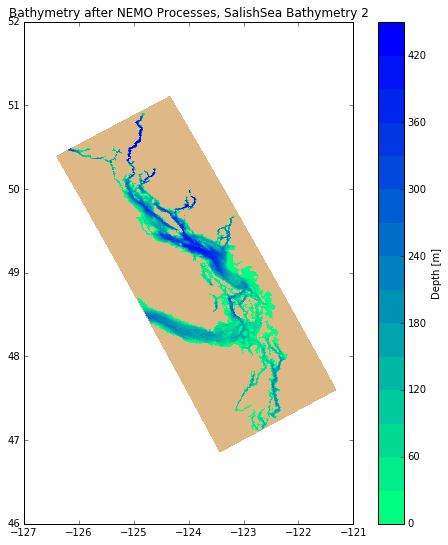

In [10]:
fig = plt.figure(figsize=(9, 9))
ax = plt.axes()
ax.set_aspect(1 / np.cos(np.median(latitude) * np.pi / 180))
plt.title(new_bathy.title)
levels = MaxNLocator(nbins=15).tick_values(0, np.max(bathymetry))
cmap = plt.get_cmap('winter_r')
norm = BoundaryNorm(levels, ncolors=cmap.N)
cmap.set_bad('burlywood')
plt.pcolormesh(longitude[:], latitude[:], bathymetry[:], cmap=cmap, norm=norm)
cbar = plt.colorbar()
cbar.set_label('Depth [m]')

In [11]:
new_bathy.close()